In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# ---------------------------------------------------------
# --- Muted color palette centered on #75896b ---
palette = {
    "primary": "#75896b",
    "blue":    "#6b7d91",
    "red":     "#a06b6b",
    "purple":  "#8a6b91",
    "amber":   "#b09b6b"
}

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Georgia", "DejaVu Serif", "Garamond"],
    "font.size": 12,
    "axes.titlesize": 15,
    "axes.labelsize": 12,
    "axes.edgecolor": "#3f4739",
    "axes.labelcolor": "#3f4739",
    "xtick.color": "#3f4739",
    "ytick.color": "#3f4739",
    "text.color": "#3f4739",
    "axes.titlepad": 10,
    "grid.color": "#c8d1bd",
    "grid.alpha": 0.6,
    "grid.linestyle": "--",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})
from IPython.display import display
# 1. read the dataset
data = pd.read_csv('Data/C2_pvpcdata_20250102_extracted.csv')

In [5]:
# structure
data.shape

(24, 15)

In [6]:
data.dtypes

Time              object
Hour               int64
Peaje_Trans       object
Periodo_Trans     object
PMD              float64
Ai1              float64
Ai2              float64
Bi               float64
Perd             float64
Green            float64
TEAr1            float64
TEAr2            float64
Peaje_Org         object
Periodo_Org        int64
源文件               object
dtype: object

In [7]:
data.describe

<bound method NDFrame.describe of           Time  Hour Peaje_Trans Periodo_Trans     PMD   Ai1   Ai2     Bi  \
0   02/01/2025     1       6.2TD            P6  137.12  2.29  0.00  0.000   
1   02/01/2025     2       6.2TD            P6  123.03  2.26  0.00  0.000   
2   02/01/2025     3       6.2TD            P6  100.20  3.55  0.00  0.000   
3   02/01/2025     4       6.2TD            P6   99.82  3.69  0.00  0.000   
4   02/01/2025     5       6.2TD            P6   99.82  3.68  0.00  0.000   
5   02/01/2025     6       6.2TD            P6  100.08  3.50  0.00  0.000   
6   02/01/2025     7       6.2TD            P6  128.44  4.10  2.92  0.000   
7   02/01/2025     8       6.2TD            P6  143.96  2.04  2.55  0.000   
8   02/01/2025     9       6.2TD            P2  152.92  1.69  2.32  0.140   
9   02/01/2025    10       6.2TD            P2  152.16  2.14  2.17  0.140   
10  02/01/2025    11       6.2TD            P1  129.04  4.77  2.12  0.844   
11  02/01/2025    12       6.2TD          

In [8]:
import pandas as pd
from datetime import timedelta

def expand_hour_to_15min(df):

    # 把日期解析为 datetime（没有时间信息）
    df["Date"] = pd.to_datetime(df["Time"], format="%d/%m/%Y")

    expanded_rows = []

    for _, row in df.iterrows():
        base_date = row["Date"]
        hour = int(row["Hour"]) - 1  # Hour=1 → 00:00

        base_time = base_date + timedelta(hours=hour)

        # 生成四个 15 分钟间隔
        for minutes in [0, 15, 30, 45]:
            new_row = row.copy()
            timestamp = base_time + timedelta(minutes=minutes)

            # ⭐ 转换为你要的输出格式（字符串）
            new_row["Time"] = timestamp.strftime("%Y-%m-%d %H:%M:%S")

            expanded_rows.append(new_row)

    expanded_df = pd.DataFrame(expanded_rows)

    expanded_df = expanded_df.drop(columns=["Date"])

    return expanded_df

df = pd.read_csv('Data/all_pvpc_data_combined.csv')
df = expand_hour_to_15min(df)
df.describe
df.to_csv("all_pvpc_data_15min.csv")

(UTC+00:00) Dublin, Edinburgh, Lisbon, London     object
UTC                                               object
L1 Site                                          float64
LPDC                                             float64
Extraction                                       float64
                                                  ...   
Perd_Factor                                      float64
Total_Cost_Estimate                              float64
Low_TOU                                            int64
High_TOU                                           int64
Load_Shift_Potential                             float64
Length: 65, dtype: object

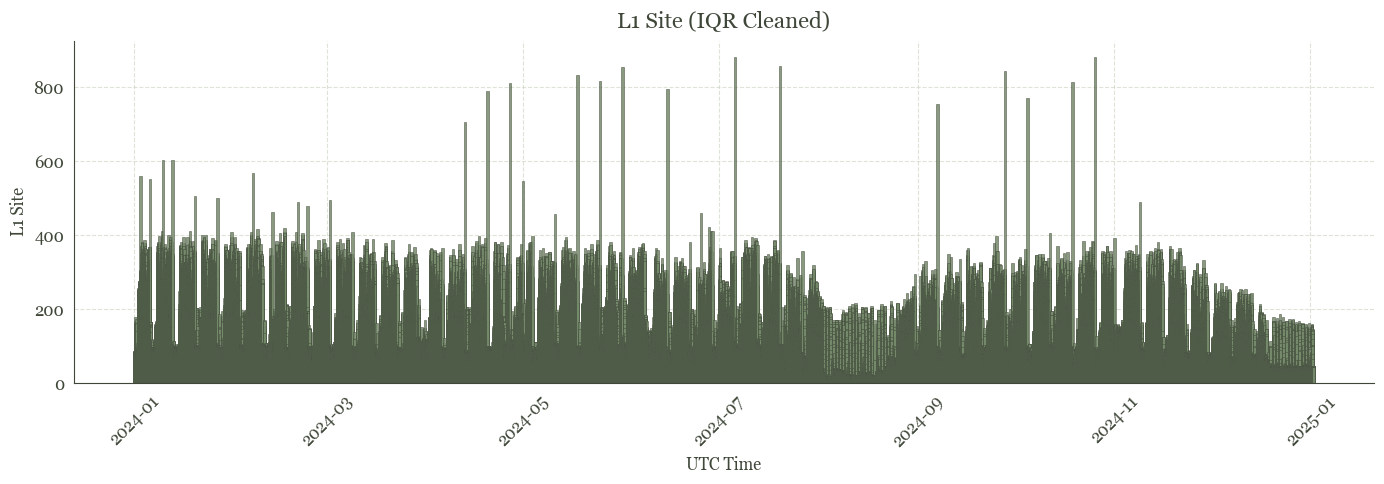

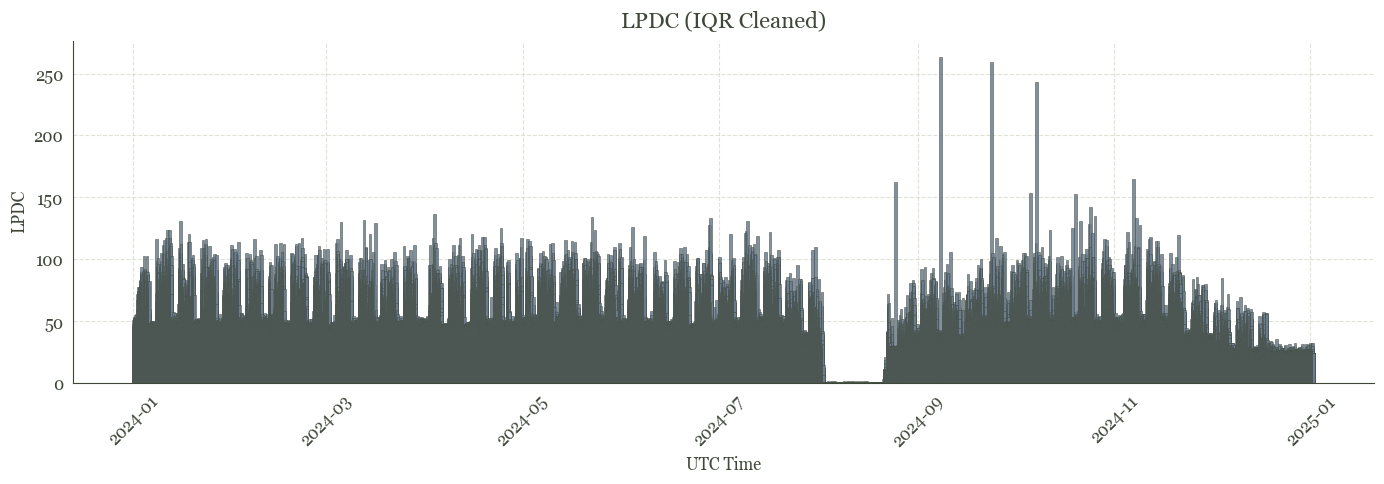

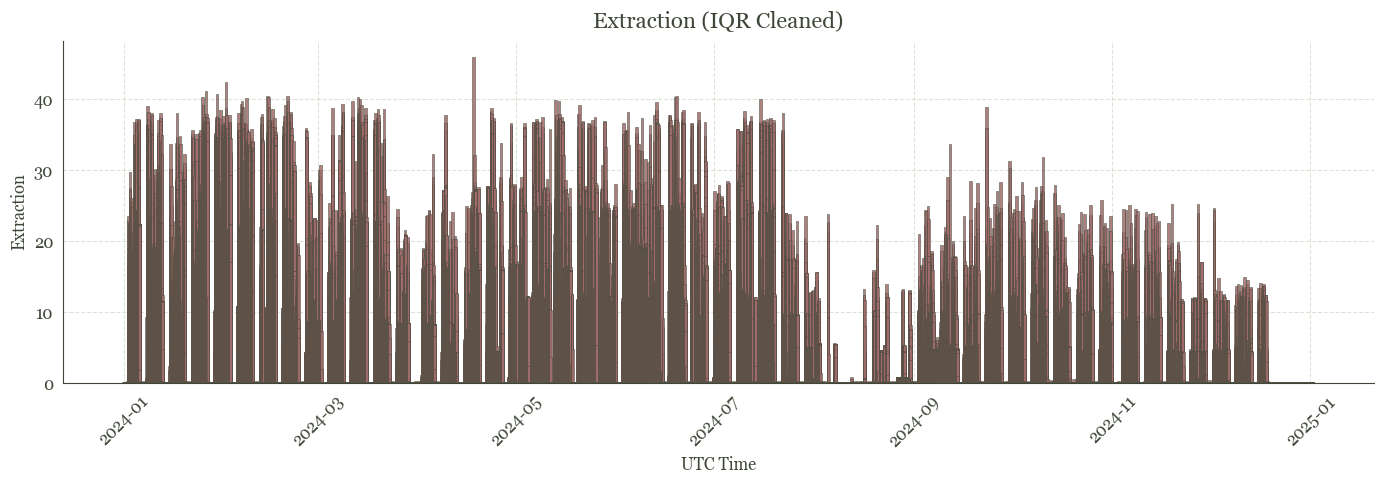

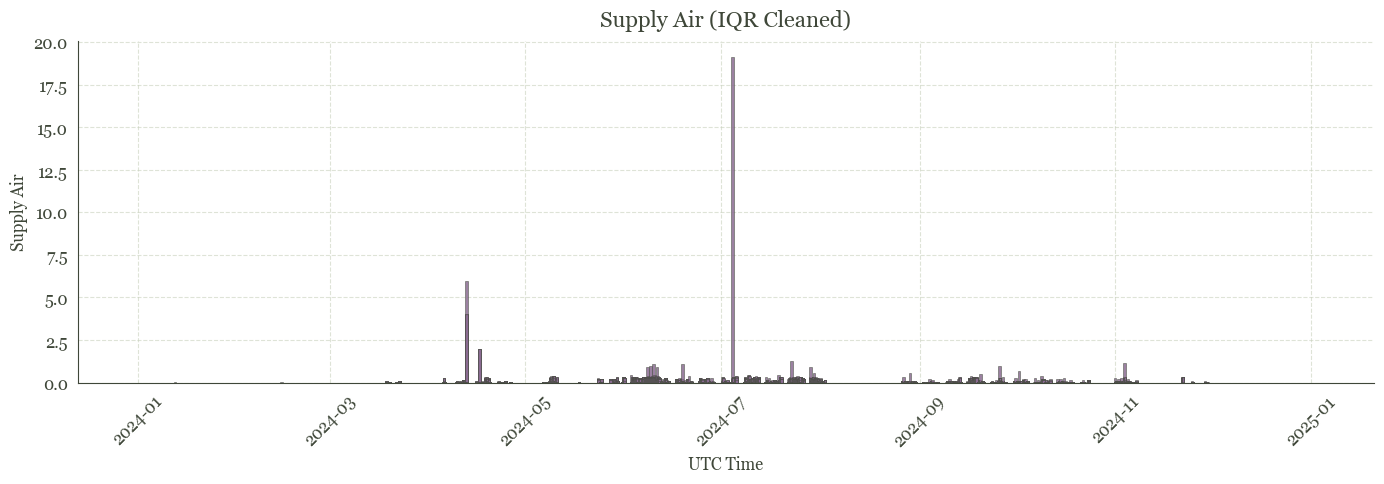

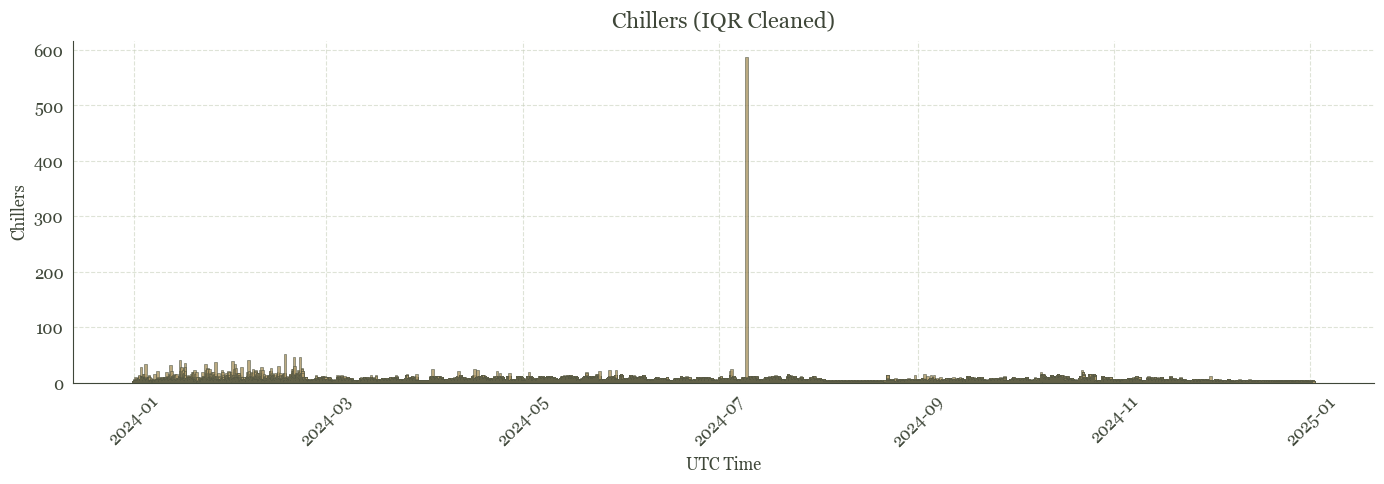

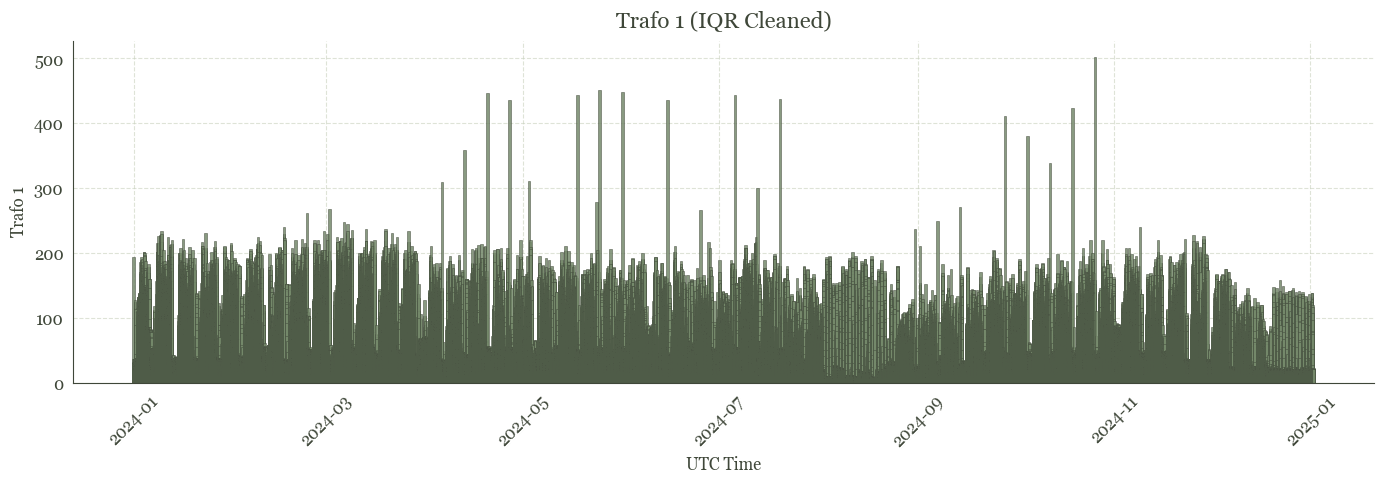

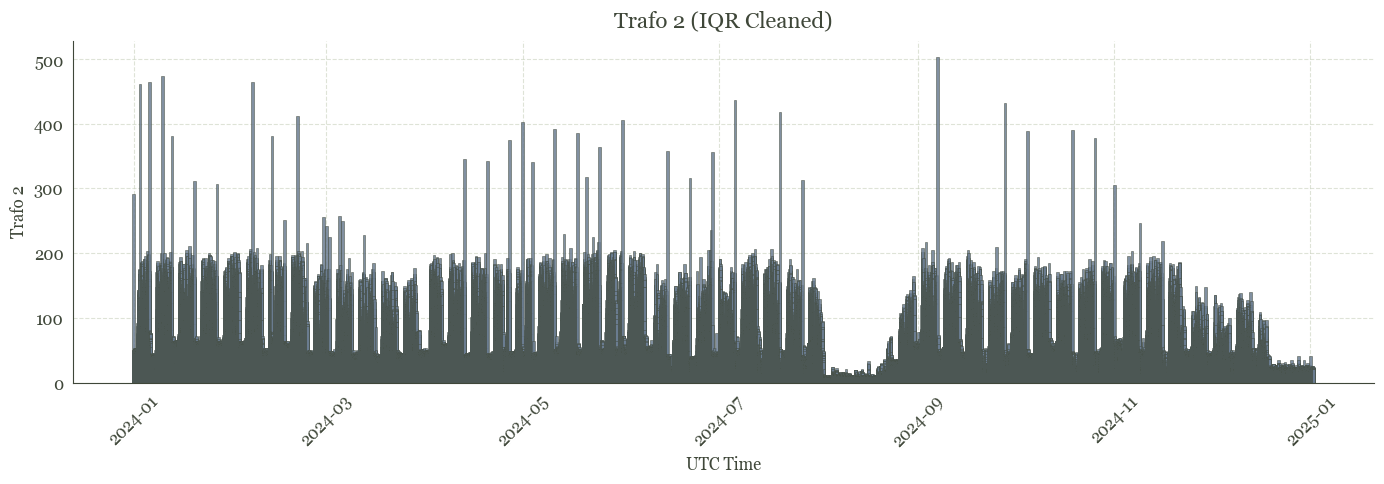

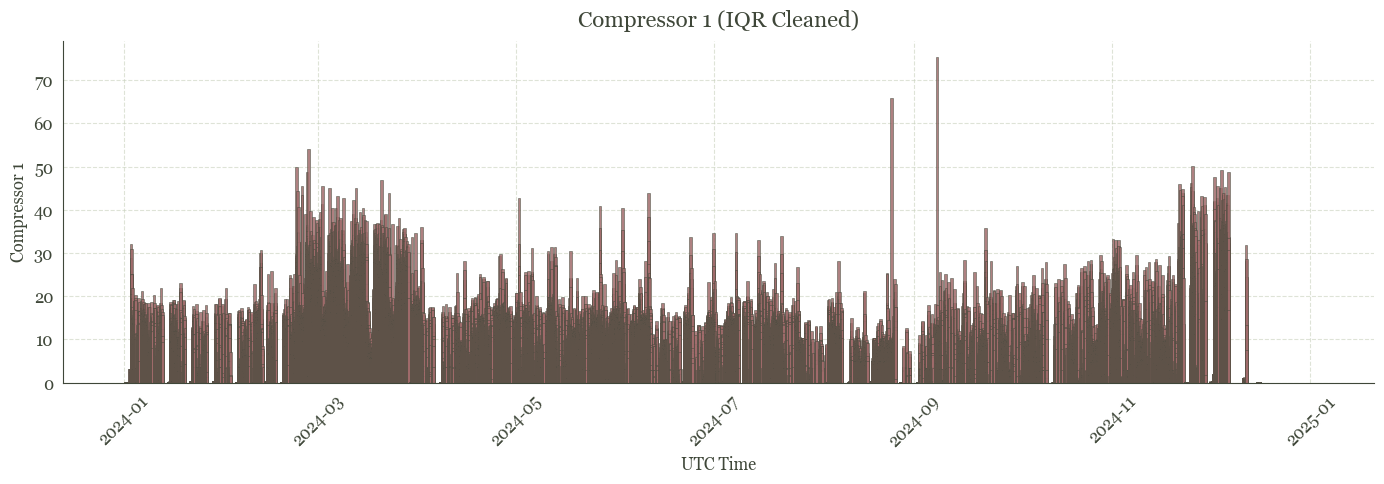

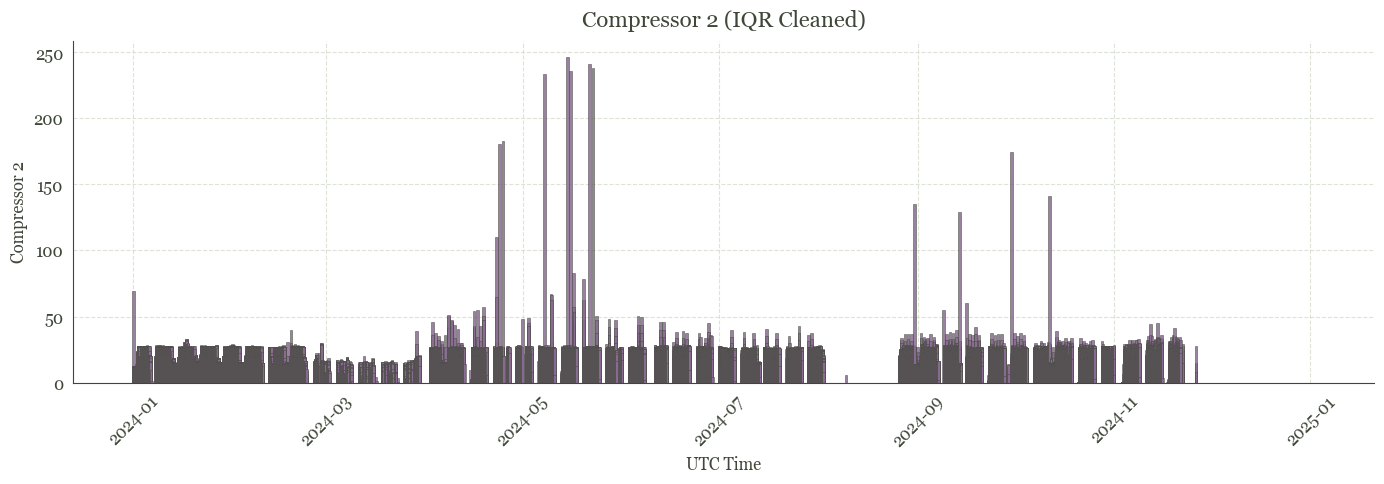

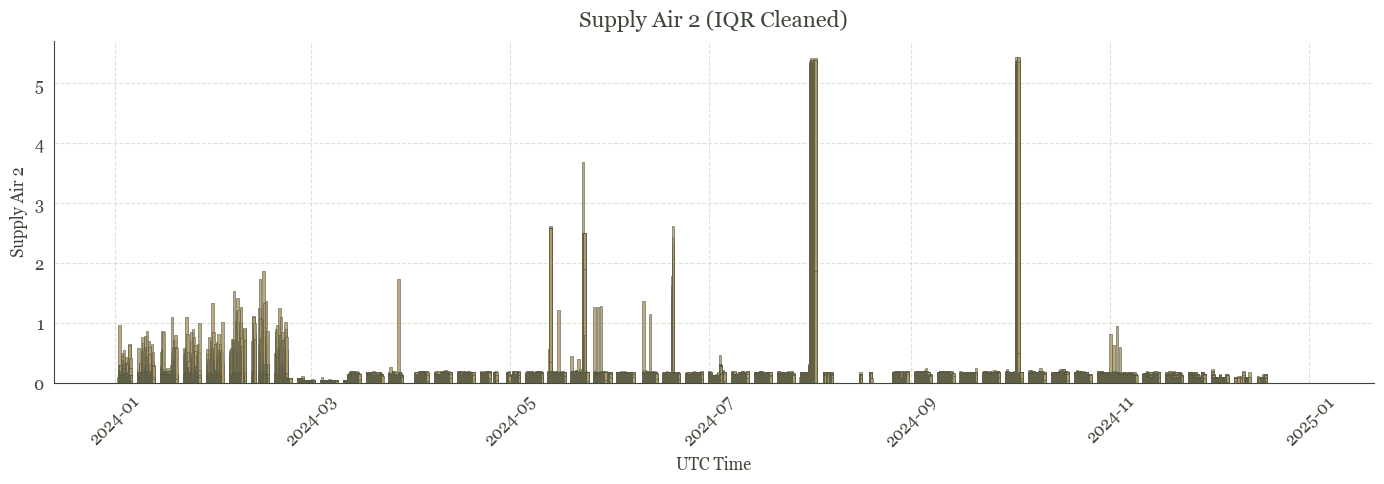

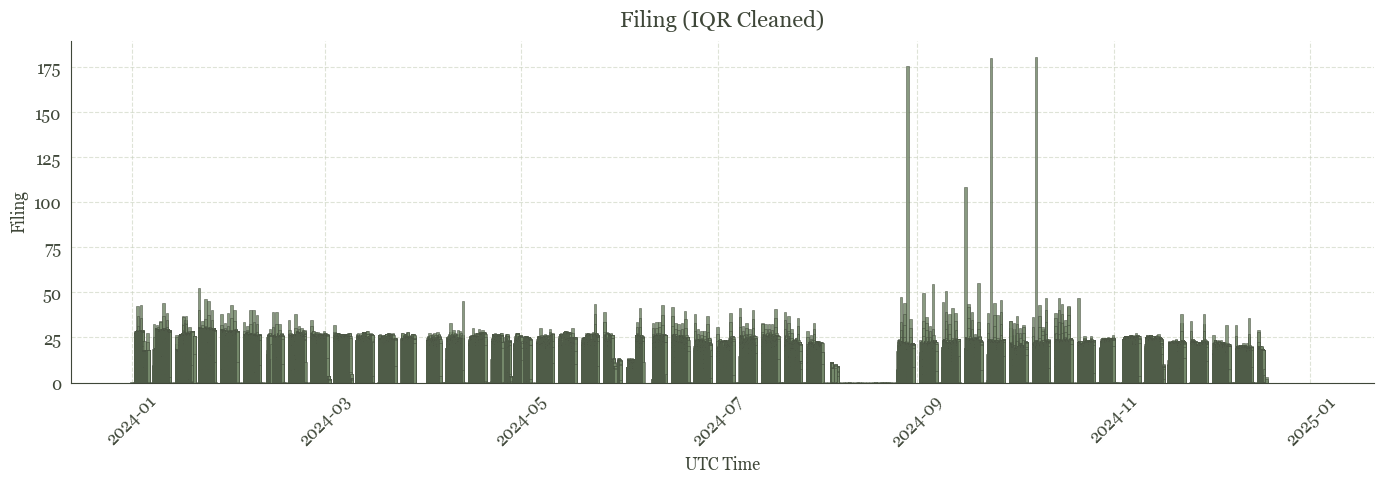

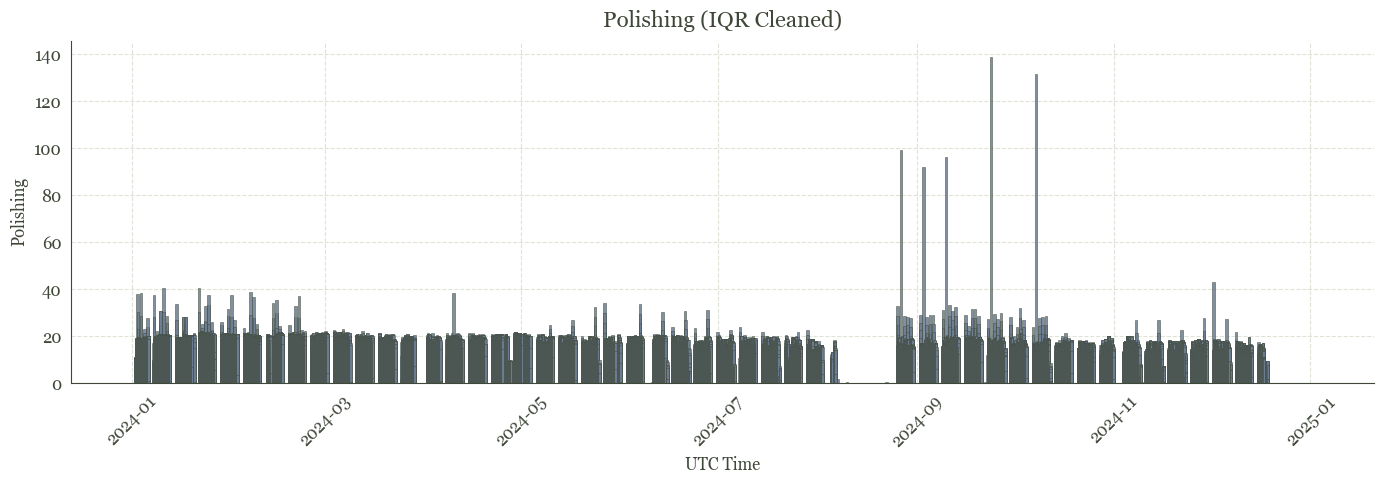

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1. IQR 去异常值
# ----------------------------------------------------
def remove_outliers_iqr(df, columns, multiplier=1.5):
    df_clean = df.copy()

    for col in columns:
        if col not in df_clean.columns:
            print(f"Warning: Column '{col}' not found, skipped.")
            continue
        if not pd.api.types.is_numeric_dtype(df_clean[col]):
            print(f"Warning: Column '{col}' is not numeric, skipped.")
            continue

        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - multiplier * IQR
        upper = Q3 + multiplier * IQR

        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

    return df_clean


# ----------------------------------------------------
# 2. 每个变量一个柱状图（自动分配不同颜色）
# ----------------------------------------------------
def plot_each_column_bar(df, columns, palette):
    """
    以每列一个图的方式绘制柱状图。
    每个图自动使用 palette 中不同的 muted 颜色。
    """

    time_col = "UTC"

    # 确保时间格式正确
    if df[time_col].dtype == "object":
        df[time_col] = pd.to_datetime(df[time_col])

    # 准备颜色循环
    palette_colors = list(palette.values())
    num_colors = len(palette_colors)

    # 生成图表
    for idx, col in enumerate(columns):

        if col not in df.columns:
            print(f"跳过：'{col}' 不在 DataFrame 中。")
            continue

        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"跳过：'{col}' 不是数值列。")
            continue

        color = palette_colors[idx % num_colors]

        plt.figure(figsize=(14, 5))

        plt.bar(df[time_col], df[col],
                color=color,
                alpha=0.85,
                edgecolor="#3f4739",
                linewidth=0.4)

        plt.title(f"{col} (IQR Cleaned)", fontsize=16)
        plt.xlabel("UTC Time")
        plt.ylabel(col)

        plt.xticks(rotation=45)
        plt.grid(True)

        plt.tight_layout()
        plt.show()

cols = [
    'L1 Site', 'LPDC', 'Extraction', 'Supply Air',
    'Chillers', 'Trafo 1', 'Trafo 2',
    'Compressor 1', 'Compressor 2',
    'Supply Air 2', 'Filing', 'Polishing'
]

plot_each_column_bar(df, cols, palette)

In [22]:
df = pd.read_csv('ML_Feature_Engineered_LoadProfile_Mainland.csv')
df.dtypes

(UTC+00:00) Dublin, Edinburgh, Lisbon, London     object
UTC                                               object
L1 Site                                          float64
LPDC                                             float64
Extraction                                       float64
                                                  ...   
Perd_Factor                                      float64
Total_Cost_Estimate                              float64
Low_TOU                                            int64
High_TOU                                           int64
Load_Shift_Potential                             float64
Length: 65, dtype: object